# Interpolating the DESI stellar templates

The goal of this notebook is to demonstrate how the DESI stellar templates, which are defined on a semi-regular grid of effective temperature, surface gravity, and iron abundance, can be interpolated onto arbitrary values of Teff, logg, and [Fe/H].

The StarInterp() Class defined below is adopted from code written by Ben Johnson (CfA) under an MIT license (https://github.com/bd-j/prospector/blob/master/prospect/sources/ssp_basis.py#L35-L266) but I'm not sure how to properly attribute it in the documentation of the Class itself.  

Briefly, the code uses a Delaunay tessellation scheme to find the simplex in Teff-logg-[Fe/H] parameter space which surrounds the desired (input) physical values and then does a weighted sum of the basis templates based on the weighted position of the point in that simplex.

The notebook also compares the interpolation scheme against spectra interpolated by Carlos Allende Prieto using a custom routine written in Fortran.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import numpy as np
import fitsio

import matplotlib.pyplot as plt

from desisim.io import read_basis_templates

In [3]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})

## Read the stellar basis templates and a random galaxia (MWS) mock.

In [4]:
baseflux, basewave, basemeta, = read_basis_templates('STAR')

INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits


In [5]:
mwspath = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'mws', 'galaxia', 'alpha', 'v0.0.4')
mwsfile = os.path.join(mwspath, 'bricks', '215', '2150p000', 'allsky_galaxia_desi_2150p000.fits')
data = fitsio.read(mwsfile, upper=True, ext=1)
data.dtype.names

('X',
 'Y',
 'Z',
 'L',
 'B',
 'RA',
 'DEC',
 'PM_L',
 'PM_B',
 'PM_RA',
 'PM_DEC',
 'PM_L_KMS',
 'PM_B_KMS',
 'PM_RA_KMS',
 'PM_DEC_KMS',
 'V_HELIO',
 'D_HELIO',
 'DM',
 'ABV',
 'SDSSU_TRUE_NODUST',
 'SDSSU_TRUE',
 'SDSSU_OBS',
 'SDSSG_TRUE_NODUST',
 'SDSSG_TRUE',
 'SDSSG_OBS',
 'SDSSR_TRUE_NODUST',
 'SDSSR_TRUE',
 'SDSSR_OBS',
 'SDSSI_TRUE_NODUST',
 'SDSSI_TRUE',
 'SDSSI_OBS',
 'SDSSZ_TRUE_NODUST',
 'SDSSZ_TRUE',
 'SDSSZ_OBS',
 'FEH',
 'AGE',
 'TEFF',
 'LOGG',
 'MTIP',
 'MACT',
 'SMASS',
 'POPID',
 'BRICKNAME',
 'BRICKID',
 'VRCYL',
 'VPHICYL',
 'VZCYL',
 'VX',
 'VY',
 'VZ',
 'VU',
 'VV',
 'VW',
 'OBJID')

## Compare the physical coverage of the models relative to the mock data.

Note the relative sparsity of intermediate-temperature models compared to cool-temperature models (the latter of which are highly over-represented), and the lack of extremely low-metallicity stars.

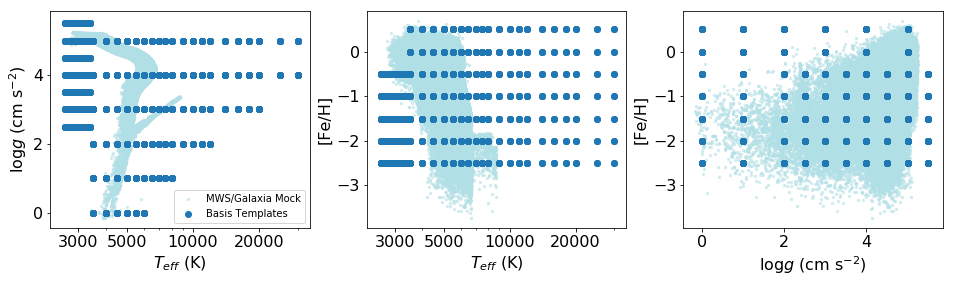

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.scatter(10**data['TEFF'], data['LOGG'], s=5, alpha=0.5, 
            color='powderblue', label='MWS/Galaxia Mock')
ax1.scatter(basemeta['TEFF'], basemeta['LOGG'], label='Basis Templates')
ax1.set_xscale('log')
ax1.set_xticks([3000, 5000, 1E4, 2E4])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel('$T_{eff}$ (K)')
ax1.set_ylabel('$\log g$ (cm s$^{-2}$)')
ax1.legend(loc='lower right', fontsize=10, markerscale=1.0)

ax2.scatter(10**data['TEFF'], data['FEH'], s=5, alpha=0.5, color='powderblue')
ax2.scatter(basemeta['TEFF'], basemeta['FEH'])
ax2.set_xscale('log')
ax2.set_xticks([3000, 5000, 1E4, 2E4])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xlabel('$T_{eff}$ (K)')
ax2.set_ylabel('[Fe/H]')

ax3.scatter(data['LOGG'], data['FEH'], s=5, alpha=0.5, color='powderblue')
ax3.scatter(basemeta['LOGG'], basemeta['FEH'])
ax3.set_ylabel('[Fe/H]')
ax3.set_xlabel('$\log g$ (cm s$^{-2}$)')

fig.subplots_adjust(wspace=0.22)

## Define the (new) interpolation class.

In [7]:
class StarInterp(object):

    _spectra = None

    def __init__(self, WD=False, verbose=False, n_neighbors=0, log_interp=True, 
                 logify_Z=True, use_params=None, rescale_params=False, **kwargs):
        """An object which holds the stellar spectral library, performs
        interpolations of that library, and has methods to return attenuated,
        normalized, smoothed stellar spectra.  The interpolations are performed
        using barycenter coordinates of the enclosing simplex found from the
        Delauynay triangulation.  This is not tractable for large dimension
        (see BigStarBasis for that case).

        :param WD: (default: False)
            If True, read the white dwarf basis templates.  Otherwise, read the (normal)
            star templates.

        :param n_neighbors: (default:0)
            Number of nearest neighbors to use when requested parameters are
            outside the convex hull of the library prameters.  If ``0`` then a
            ValueError is raised instead of the nearest spectrum.

        :param verbose:
            If True, print information about the parameters used when a point
            is outside the convex hull.

        :param log_interp: (default:True)
            Switch to interpolate in log(flux) instead of linear flux.

        :param use_params:
            Sequence of strings. If given, only use the listed parameters
            (which must be present in the `_libparams` structure) to build the
            grid and construct spectra.  Otherwise all fields of `_libparams`
            will be used.

        :param rescale: (default: False)
            If True, rescale the parameters to the unit cube before generating
            the triangulation.  Note that the `param_vector` method will also
            rescale the input parameters in this case.
        """
        # Cache initialization variables
        self.verbose = verbose
        self.logarithmic = log_interp
        self.logify_Z = logify_Z
        self.n_neighbors = n_neighbors
        self._rescale = rescale_params

        # Load the templates
        self.load_templates(WD=WD)

        # Do some important bookkeeping
        if use_params:
            self.stellar_pars = tuple(use_params)
        else:
            self.stellar_pars = self._libparams.dtype.names
        self.ndim = len(self.stellar_pars)

        # Build the triangulation and kdtree
        self.triangulate()
        self.build_kdtree()

        self.params = {}

    @property
    def wavelengths(self):
        return self._wave
    
    def load_templates(self, WD=False):
        """Read the DESI stellar or white dwarf basis templates.  The ``wavelengths``, 
        ``parameters`` and ``spectra`` attributes are ndarrays of shape (nwave,), 
        (nmodels,), and (nmodels, nwave), respectively and the ``parameters`` array 
        is a structured array.
        
        """
        from desisim.io import read_basis_templates

        if WD:
            objtype = 'WD'
            stellar_pars = ('TEFF', 'LOGG')
        else:
            objtype = 'STAR'
            stellar_pars = ('TEFF', 'LOGG', 'FEH') # need a case for WDs

        self._spectra, self._wave, meta = read_basis_templates(objtype)

        # Extract the parameter files from the astropy.Table into a np.ndarray.
        params = np.ndarray( (len(meta), ), dtype=[(p, 'f4') for p in stellar_pars])
        for pp in stellar_pars:
            params[pp] = meta[pp]
        
        self._libparams = params

        if self.logify_Z and 'Z' in self._libparams.dtype.names:
            from numpy.lib import recfunctions as rfn
            self._libparams['Z'] = np.log10(self._libparams['Z'])
            rfn.rename_fields(self._libparams, {'Z': 'logZ'})

    def triangulate(self):
        """Build the Delauynay Triangulation of the model library."""
        from scipy.spatial import Delaunay
        # slow.  should use a view based method
        model_points = np.array([list(self._libparams[d]) for d in self.stellar_pars]).T
        if self._rescale:
            self.parameter_range = np.array([model_points.min(axis=0), model_points.max(axis=0)])
            model_points = self.rescale_params(model_points)
        self._dtri = Delaunay(model_points)

    def build_kdtree(self):
        """Build the kdtree of the model points."""
        # slow.  should use a view based method
        from scipy.spatial import cKDTree as KDTree
        model_points = np.array([list(self._libparams[d])
                                 for d in self.stellar_pars])
        self._kdt = KDTree(model_points.T)

    def rescale_params(self, points):
        if self._rescale:
            x = np.atleast_2d(points)
            x = (x - self.parameter_range[0, :]) / np.diff(self.parameter_range, axis=0)
            return np.squeeze(x)
        else:
            return points

    def param_vector(self, **kwargs):
        """Take a dictionary of parameters and return the stellar library
        parameter vector corresponding to these parameters as an ndarray.
        Raises a KeyError if the dictionary does not contain *all* of the
        required stellar parameters.
        
        """
        pvec = [kwargs[n] for n in self.stellar_pars]
        return self.rescale_params(np.array(pvec))

    def weights_kNN(self, target_points, k=1):
        """The interpolation weights are determined from the inverse distance
        to the k nearest neighbors.

        :param target_points: ndarray, shape(ntarg,npar)
            The coordinates to which you wish to interpolate.

        :param k:
            The number of nearest neighbors to use.

        :returns inds: ndarray, shape(ntarg,npar+1)
             The model indices of the interpolates.

        :returns weights: narray, shape (ntarg,npar+1)
             The weights of each model given by ind in the interpolates.
             
        """
        # In some cases the distances are all the same...
        dists, inds = self._kdt.query(target_points, k=k)
        
        inds = np.atleast_1d(np.squeeze(inds))
        if k == 1:
            return inds, np.ones(inds.shape)
        weights = 1 / dists
        # weights[np.isinf(weights)] = large_number
        weights = weights / weights.sum(axis=-1)
        return inds, np.atleast_1d(np.squeeze(weights))

    def weights(self, **kwargs):
        """Delauynay weighting.  Return indices of the models forming the
        enclosing simplex, as well as the barycentric coordinates of the point
        within this simplex to use as weights.  If point is outside the convex
        hull then fallback to nearest neighbor unless ``n_neighbors`` is 0.
        
        """
        from itertools import chain
        
        inparams = np.squeeze(self.param_vector(**kwargs))
        triangle_ind = self._dtri.find_simplex(inparams)
        if triangle_ind == -1:
            self.edge_flag = True
            if self.n_neighbors == 0:
                pstring = ', '.join(self.ndim * ['{}={}'])
                pstring = pstring.format(*chain(*zip(self.stellar_pars, inparams)))
                raise ValueError("Requested spectrum ({}) outside convex hull,"
                                 " and nearest neighbor interpolation turned "
                                 "off.".format(*pstring))
            ind, wght = self.weights_kNN(inparams, k=self.n_neighbors)
            if self.verbose:
                print("Parameters {0} outside model convex hull. "
                      "Using model index {1} instead. ".format(inparams, ind))
            return ind, wght

        inds = self._dtri.simplices[triangle_ind, :]
        transform = self._dtri.transform[triangle_ind, :, :]
        Tinv = transform[:self.ndim, :]
        x_r = inparams - transform[self.ndim, :]
        bary = np.dot(Tinv, x_r)
        last = 1.0 - bary.sum()
        wghts = np.append(bary, last)
        oo = inds.argsort()
        return inds[oo], wghts[oo]

    def get_spectrum(self, **kwargs):
        """Given stellar parameters, obtain an interpolated spectrum at those
        parameters.

        :param **kwargs:
            Keyword arguments must include values for the parameters listed in
            ``stellar_pars``.

        :returns wave:
            The wavelengths at which the spectrum is defined.

        :returns spec:
            The spectrum interpolated to the requested parameters.  This has
            the same units as the supplied library spectra.

        :returns unc:
            The uncertainty spectrum, where the uncertainty is due to
            interpolation error.  Curently unimplemented (i.e. it is a None
            type object).
        """
        inds, wghts = self.weights(**kwargs)
        if self.logarithmic:
            spec = np.exp(np.dot(wghts, np.log(self._spectra[inds, :])))
        else:
            spec = np.dot(wghts, self._spectra[inds, :])
        spec_unc = None
        return self._wave, spec, spec_unc

## Demonstrate how to use the StarInterp Class.

In [8]:
Star = StarInterp(n_neighbors=5)

INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits


### Choose typical values and visualize the models used for the interpolation.

In [9]:
teff, feh, logg = 6253, -0.06, 3.22
%timeit wave, flux, ferr = Star.get_spectrum(TEFF=teff, FEH=feh, LOGG=logg)

100 loops, best of 3: 7.53 ms per loop


In [10]:
indx, wght = Star.weights(TEFF=teff, FEH=feh, LOGG=logg)
print(indx, wght)

[538 544 546 587] [ 0.22   0.12   0.154  0.506]


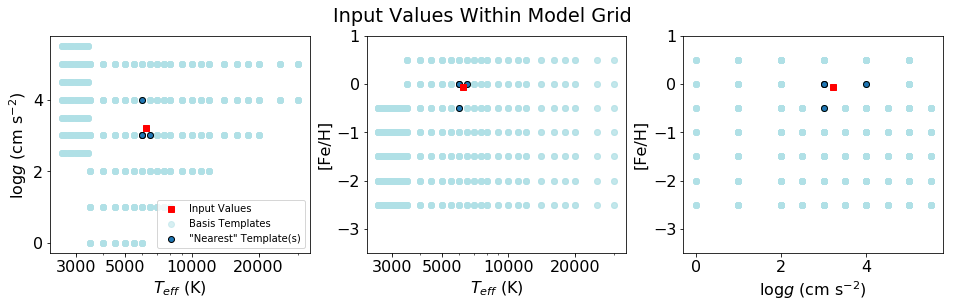

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.scatter(Star._libparams['TEFF'], Star._libparams['LOGG'], 
            alpha=0.5, color='powderblue', label='Basis Templates')
ax1.scatter(Star._libparams['TEFF'][indx], Star._libparams['LOGG'][indx], 
            edgecolor='k', label='"Nearest" Template(s)')
ax1.plot(teff, logg, 's', color='red', label='Input Values')
ax1.legend(loc='lower right', fontsize=10)
ax1.set_xscale('log')
ax1.set_xticks([3000, 5000, 1E4, 2E4])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel('$T_{eff}$ (K)')
ax1.set_ylabel('$\log g$ (cm s$^{-2}$)')

ax2.scatter(Star._libparams['TEFF'], Star._libparams['FEH'],
            alpha=0.5, color='powderblue')
ax2.scatter(Star._libparams['TEFF'][indx], Star._libparams['FEH'][indx],
            edgecolor='k')
ax2.plot(teff, feh, 's', color='red')
ax2.set_ylim(-3.5, 1)
ax2.set_xscale('log')
ax2.set_xticks([3000, 5000, 1E4, 2E4])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xlabel('$T_{eff}$ (K)')
ax2.set_ylabel('[Fe/H]')

ax3.scatter(Star._libparams['LOGG'], Star._libparams['FEH'],
            alpha=0.5, color='powderblue')
ax3.scatter(Star._libparams['LOGG'][indx], Star._libparams['FEH'][indx],
            edgecolor='k')
ax3.plot(logg, feh, 's', color='red')
ax3.set_ylabel('[Fe/H]')
ax3.set_ylim(-3.5, 1)
ax3.set_xlabel('$\log g$ (cm s$^{-2}$)')

plt.suptitle('Input Values Within Model Grid')

fig.subplots_adjust(wspace=0.22)

### Choose values outside the model grid boundaries.

In [12]:
teff2, feh2, logg2 = 6253, -3.1, 4.5
%timeit wave, flux, ferr = Star.get_spectrum(TEFF=teff2, FEH=feh2, LOGG=logg2)
#wave, flux, ferr = Star.get_spectrum(TEFF=teff, FEH=feh, LOGG=logg)

100 loops, best of 3: 8.36 ms per loop


In [13]:
indx2, wght2 = Star.weights(TEFF=teff2, FEH=feh2, LOGG=logg2)
print(indx2, wght2)

[568 575 576 569 582] [ 0.20000121  0.20000121  0.19999982  0.19999982  0.19999793]


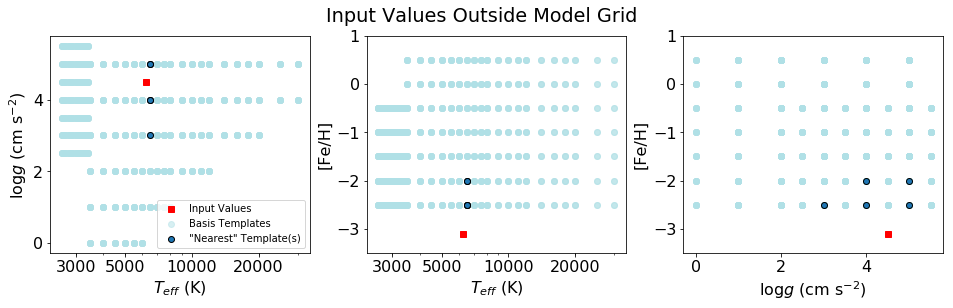

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.scatter(Star._libparams['TEFF'], Star._libparams['LOGG'], 
            alpha=0.5, color='powderblue', label='Basis Templates')
ax1.scatter(Star._libparams['TEFF'][indx2], Star._libparams['LOGG'][indx2], 
            edgecolor='k', label='"Nearest" Template(s)')
ax1.plot(teff2, logg2, 's', color='red', label='Input Values')
ax1.legend(loc='lower right', fontsize=10, frameon=True)
ax1.set_xscale('log')
ax1.set_xticks([3000, 5000, 1E4, 2E4])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel('$T_{eff}$ (K)')
ax1.set_ylabel('$\log g$ (cm s$^{-2}$)')

ax2.scatter(Star._libparams['TEFF'], Star._libparams['FEH'],
            alpha=0.5, color='powderblue')
ax2.scatter(Star._libparams['TEFF'][indx2], Star._libparams['FEH'][indx2],
            edgecolor='k')
ax2.plot(teff2, feh2, 's', color='red')
ax2.set_ylim(-3.5, 1)
ax2.set_xscale('log')
ax2.set_xticks([3000, 5000, 1E4, 2E4])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xlabel('$T_{eff}$ (K)')
ax2.set_ylabel('[Fe/H]')

ax3.scatter(Star._libparams['LOGG'], Star._libparams['FEH'],
            alpha=0.5, color='powderblue')
ax3.scatter(Star._libparams['LOGG'][indx2], Star._libparams['FEH'][indx2],
            edgecolor='k')
ax3.plot(logg2, feh2, 's', color='red')
ax3.set_ylim(-3.5, 1)
ax3.set_ylabel('[Fe/H]')
ax3.set_xlabel('$\log g$ (cm s$^{-2}$)')

plt.suptitle('Input Values Outside Model Grid')

fig.subplots_adjust(wspace=0.22)

## Compare the interpolated spectra against Carlos'.

Carlos has provided interpolated spectra using three different interpolation schemes: linear (o1), quadratic (o2), and cubic (o3).  Note that these are on the same wavelength grid (and resolution) as the basis templates themselves.

### Read Carlos' spectra and parameter values.

In [15]:
opath = os.path.join(os.getenv('DESI_ROOT'), 'data', 'mwsinterp')
oflux, odata = list(), list()
for interp in ('o1', 'o2', 'o3'):
    ofile = os.path.join(opath, interp, 'nsc1.fits')
    odata.append(fitsio.read(ofile, ext=1))
    oflux.append(fitsio.read(ofile, ext=2))
    if interp == 'o1': # all the parameter values are the same
        nstar, npix = oflux[0].shape
        oparam = {'FEH': odata[0]['OPARAM'][:, 0],
                  'TEFF': odata[0]['OPARAM'][:, 1],
                  'LOGG': odata[0]['OPARAM'][:, 2]}

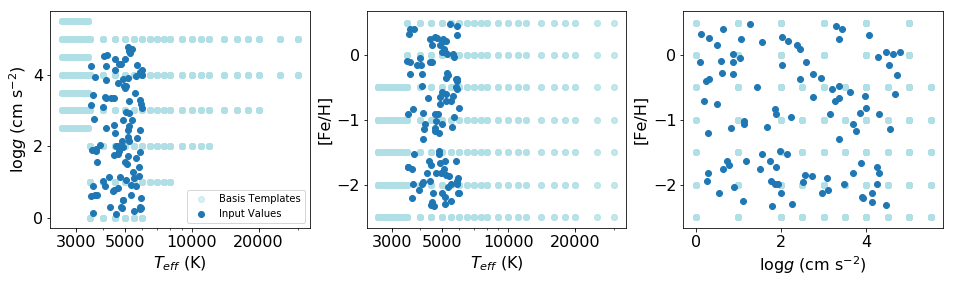

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.scatter(Star._libparams['TEFF'], Star._libparams['LOGG'], 
            alpha=0.5, color='powderblue', label='Basis Templates')
ax1.scatter(oparam['TEFF'], oparam['LOGG'], label='Input Values')
ax1.legend(loc='lower right', fontsize=10, frameon=True)
ax1.set_xscale('log')
ax1.set_xticks([3000, 5000, 1E4, 2E4])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel('$T_{eff}$ (K)')
ax1.set_ylabel('$\log g$ (cm s$^{-2}$)')

ax2.scatter(Star._libparams['TEFF'], Star._libparams['FEH'],
            alpha=0.5, color='powderblue')
ax2.scatter(oparam['TEFF'], oparam['FEH'])
ax2.set_xscale('log')
ax2.set_xticks([3000, 5000, 1E4, 2E4])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xlabel('$T_{eff}$ (K)')
ax2.set_ylabel('[Fe/H]')

ax3.scatter(Star._libparams['LOGG'], Star._libparams['FEH'],
            alpha=0.5, color='powderblue')
ax3.scatter(oparam['LOGG'], oparam['FEH'])
ax3.set_ylabel('[Fe/H]')
ax3.set_xlabel('$\log g$ (cm s$^{-2}$)')

fig.subplots_adjust(wspace=0.22)

### Do the interpolation and compare the results.

In [17]:
wave = Star.wavelengths
flux = np.ndarray( (nstar, npix) ).astype('f4')
for ii in range(nstar):
    _, flux1, _ = Star.get_spectrum(TEFF=oparam['TEFF'][ii], 
                                    FEH=oparam['FEH'][ii], 
                                    LOGG=oparam['LOGG'][ii])
    flux[ii, :] = flux1

In [18]:
resid = np.ndarray( (3, nstar, len(wave)) )
for ii in range(3):
    for jj in range(nstar):
        resid[ii, jj, :] = 100 * (flux[jj, :] / oflux[ii][jj, :] - 1)

In [19]:
nshow = 10
seed = 123
rand = np.random.RandomState(seed)
these = rand.choice(nstar, nshow)
print(these)

[66 92 98 17 83 57 86 97 96 47]


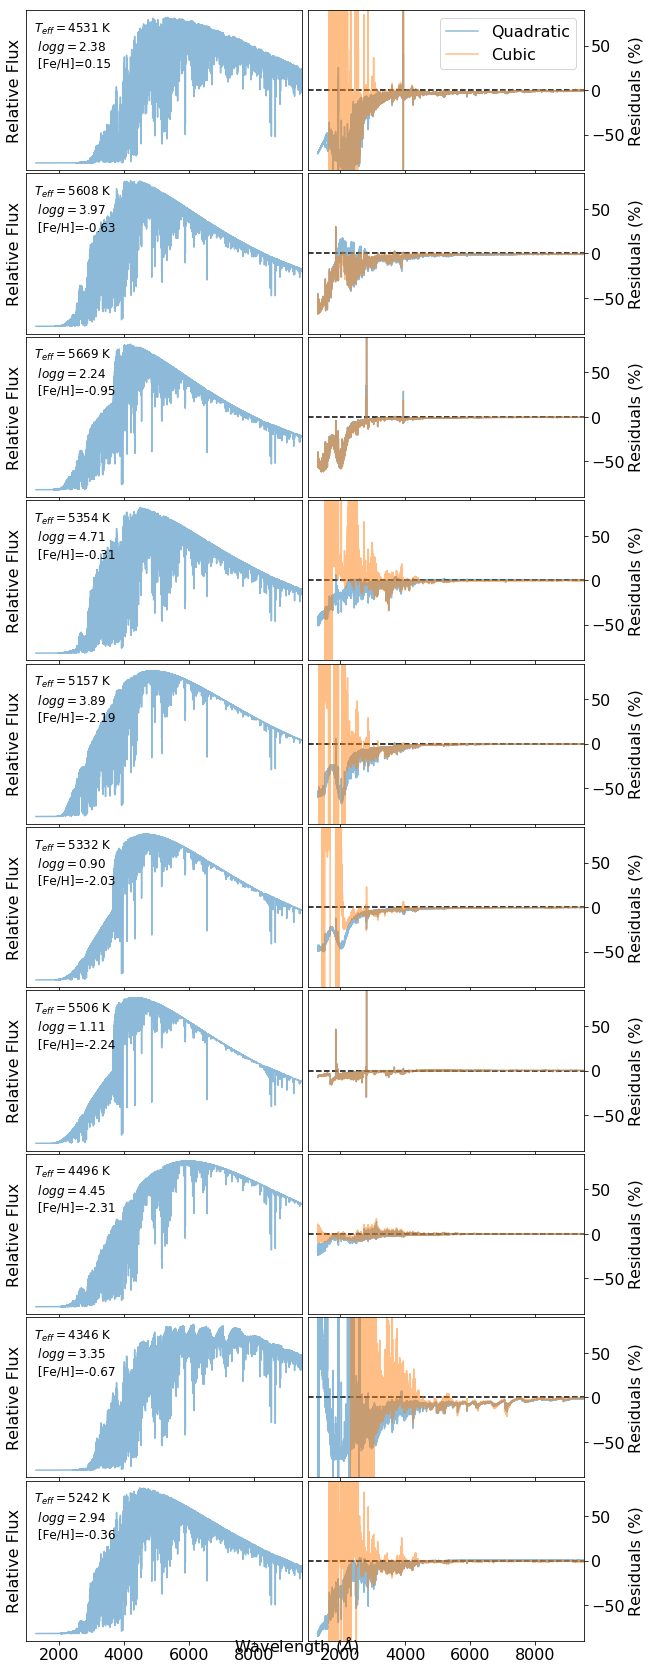

In [20]:
lbl = ('Linear', 'Quadratic', 'Cubic')

fig, ax = plt.subplots(nshow, 2, figsize=(10, 3 * nshow), sharex=True)
for jj in range(nshow):
    ax[jj, 0].plot(wave, flux[these[jj], :], alpha=0.5)
    ax[jj, 0].set_yticks([])
    ax[jj, 0].set_ylabel('Relative Flux')
    ax[jj, 0].text(0.03, 0.94, 
                   '$T_{{eff}}={:.0f}$ K\n $log g={:.2f}$\n [Fe/H]={:.2f}'.format(
                       oparam['TEFF'][these[jj]], oparam['LOGG'][these[jj]], oparam['FEH'][these[jj]]),
                   horizontalalignment='left', verticalalignment='top', 
                   transform=ax[jj, 0].transAxes, fontsize=12)

for jj in range(nshow):
    ax[jj, 1].set_ylim(-90, 90)
    ax[jj, 1].axhline(y=0, ls='--', color='k')
    ax[jj, 1].yaxis.tick_right()
    ax[jj, 1].yaxis.set_label_position('right')
    ax[jj, 1].set_ylabel('Residuals (%)')
    #ax[jj, 1].set_xlabel(r'Wavelength (\AA)')
    ax[jj, 1].set_xlim(1000, 9500)
    for ii in range(1, 3):
        ax[jj, 1].plot(wave, resid[ii, these[jj], :], 
                       alpha=0.5, label=lbl[ii])
    if jj == 0:
        ax[jj, 1].legend(loc='upper right')

fig.text(0.5, 0.12, 'Wavelength ($\AA$)', ha='center')
   
fig.subplots_adjust(wspace=0.02, hspace=0.02)

# Conclusions

Although the method used here should be robust, there are significant systematic residuals blueward of ~5000 A for both the quadratic and cubic interpolation schemes, especially (not surprisingly) at low temperature and high metallicity.

One possibility is that a template grid which is more finely defined in physical parameter space would help. Alternatively, perhaps the quadratic and cubic interpolation schemes are not as close to "truth" as we think.